In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
from tqdm import tqdm

class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(784, 256) 
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [46]:
#torch.manual_seed(7)

In [47]:
train_dataset = MNIST(os.getcwd(), train=True, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_train = train_dataset.data / 255.0
y_train = F.one_hot(train_dataset.targets, num_classes=10)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.view(-1, 784)
dtrain = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = DataLoader(dtrain, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_58371/112231088.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_58371/112231088.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


In [48]:
testDataset = MNIST(os.getcwd(), train=False, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_test = testDataset.data / 255.0
y_test = F.one_hot(testDataset.targets, num_classes=10)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_test = x_test.view(-1, 784)
dtest = torch.utils.data.TensorDataset(x_test, y_test)
testloader = DataLoader(dtest, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_58371/3473755828.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_58371/3473755828.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [49]:
def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl.weight)
    noul = torch.zeros_like(oul.weight)

    for i in range(inl.weight.data.shape[0]):
        inc = np.sqrt(torch.sum(torch.square(inl.weight.data[i])).item())
        outg = np.sqrt(torch.sum(torch.square(oul.weight.data[:,i])).item())

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.weight.data[i]*opt
        noul[:, i] = oul.weight.data[:,i]/opt

    inl.weight.data = ninc
    oul.weight.data = noul


In [50]:
model = model
lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

acc = []

num_epochs = 100  
for epoch in range(num_epochs):
    ttot = 0
    tcorr = 0
    for b in tqdm(trainloader):
        xt, y = b[0], b[1]
        optimizer.zero_grad() 
        outputs = model(xt)  
        loss = criterion(outputs, y) 
        
        loss.backward() 
        optimizer.step() 
    
        _, y = torch.max(y.data, 1)
        _, pred = torch.max(outputs.data, 1)
        ttot += y.shape[0]
        tcorr += (pred == y).sum().item()
    
    # for i in range(len(lay)):
    #     if i > 0 and i <= len(lay)-1:
    #         di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])

    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}, train dataset accuracy: {100*tcorr/ttot}')
        
    tot = 0
    corr = 0

    with torch.no_grad():
        for i in testloader:
            xt, y = i[0], i[1]
            outputs = model(xt)  
            _, y = torch.max(y.data, 1)
            _, pred = torch.max(outputs.data, 1)
            tot += y.shape[0]
            corr += (pred == y).sum().item()
    print(f'test dataset accuracy: {100*corr/tot}%')
    acc.append(corr/tot)


Linear
Linear
Linear
Linear
Linear


100%|██████████| 235/235 [00:01<00:00, 136.14it/s]


Epoch 0/100, Loss: 0.05615578591823578, train dataset accuracy: 30.796666666666667
test dataset accuracy: 53.59%


100%|██████████| 235/235 [00:01<00:00, 142.69it/s]


Epoch 1/100, Loss: 0.020121432840824127, train dataset accuracy: 82.0
test dataset accuracy: 86.3%


100%|██████████| 235/235 [00:01<00:00, 153.33it/s]


Epoch 2/100, Loss: 0.02332386001944542, train dataset accuracy: 87.14
test dataset accuracy: 88.63%


100%|██████████| 235/235 [00:01<00:00, 159.26it/s]


Epoch 3/100, Loss: 0.02280220203101635, train dataset accuracy: 88.53
test dataset accuracy: 89.39%


100%|██████████| 235/235 [00:01<00:00, 169.74it/s]


Epoch 4/100, Loss: 0.02230863645672798, train dataset accuracy: 89.295
test dataset accuracy: 89.5%


100%|██████████| 235/235 [00:01<00:00, 169.10it/s]


Epoch 5/100, Loss: 0.014169578440487385, train dataset accuracy: 90.03
test dataset accuracy: 90.04%


100%|██████████| 235/235 [00:01<00:00, 165.30it/s]


Epoch 6/100, Loss: 0.010671940632164478, train dataset accuracy: 90.155
test dataset accuracy: 90.03%


100%|██████████| 235/235 [00:01<00:00, 171.59it/s]


Epoch 7/100, Loss: 0.013942963443696499, train dataset accuracy: 90.70166666666667
test dataset accuracy: 90.18%


100%|██████████| 235/235 [00:01<00:00, 160.63it/s]


Epoch 8/100, Loss: 0.008566352538764477, train dataset accuracy: 90.69833333333334
test dataset accuracy: 90.75%


100%|██████████| 235/235 [00:01<00:00, 169.61it/s]


Epoch 9/100, Loss: 0.011669310741126537, train dataset accuracy: 91.00833333333334
test dataset accuracy: 90.79%


100%|██████████| 235/235 [00:01<00:00, 164.85it/s]


Epoch 10/100, Loss: 0.016416070982813835, train dataset accuracy: 91.14
test dataset accuracy: 90.84%


100%|██████████| 235/235 [00:01<00:00, 146.39it/s]


Epoch 11/100, Loss: 0.01579568348824978, train dataset accuracy: 91.225
test dataset accuracy: 91.08%


100%|██████████| 235/235 [00:01<00:00, 134.65it/s]


Epoch 12/100, Loss: 0.017800478264689445, train dataset accuracy: 91.45
test dataset accuracy: 91.04%


100%|██████████| 235/235 [00:01<00:00, 158.32it/s]


Epoch 13/100, Loss: 0.015579060651361942, train dataset accuracy: 91.52333333333333
test dataset accuracy: 91.1%


100%|██████████| 235/235 [00:01<00:00, 148.41it/s]


Epoch 14/100, Loss: 0.015457618981599808, train dataset accuracy: 91.575
test dataset accuracy: 90.52%


100%|██████████| 235/235 [00:01<00:00, 163.99it/s]


Epoch 15/100, Loss: 0.022613368928432465, train dataset accuracy: 91.57333333333334
test dataset accuracy: 91.31%


100%|██████████| 235/235 [00:01<00:00, 131.71it/s]


Epoch 16/100, Loss: 0.0162418931722641, train dataset accuracy: 91.64666666666666
test dataset accuracy: 91.19%


100%|██████████| 235/235 [00:01<00:00, 155.39it/s]


Epoch 17/100, Loss: 0.017001552507281303, train dataset accuracy: 91.83166666666666
test dataset accuracy: 91.35%


100%|██████████| 235/235 [00:01<00:00, 162.07it/s]


Epoch 18/100, Loss: 0.008887588046491146, train dataset accuracy: 91.89
test dataset accuracy: 91.09%


100%|██████████| 235/235 [00:01<00:00, 169.81it/s]


Epoch 19/100, Loss: 0.01883547380566597, train dataset accuracy: 91.75
test dataset accuracy: 91.38%


100%|██████████| 235/235 [00:01<00:00, 169.09it/s]


Epoch 20/100, Loss: 0.010401949286460876, train dataset accuracy: 91.93166666666667
test dataset accuracy: 90.95%


100%|██████████| 235/235 [00:01<00:00, 171.58it/s]


Epoch 21/100, Loss: 0.007888385094702244, train dataset accuracy: 91.92666666666666
test dataset accuracy: 90.88%


100%|██████████| 235/235 [00:01<00:00, 161.95it/s]


Epoch 22/100, Loss: 0.013172728940844536, train dataset accuracy: 91.9
test dataset accuracy: 91.44%


100%|██████████| 235/235 [00:01<00:00, 172.08it/s]


Epoch 23/100, Loss: 0.015733715146780014, train dataset accuracy: 91.9
test dataset accuracy: 91.33%


100%|██████████| 235/235 [00:01<00:00, 170.86it/s]


Epoch 24/100, Loss: 0.014420402236282825, train dataset accuracy: 92.04666666666667
test dataset accuracy: 91.18%


100%|██████████| 235/235 [00:01<00:00, 172.61it/s]


Epoch 25/100, Loss: 0.013600648380815983, train dataset accuracy: 92.05333333333333
test dataset accuracy: 91.55%


100%|██████████| 235/235 [00:01<00:00, 167.63it/s]


Epoch 26/100, Loss: 0.01436701975762844, train dataset accuracy: 92.095
test dataset accuracy: 91.37%


100%|██████████| 235/235 [00:01<00:00, 171.54it/s]


Epoch 27/100, Loss: 0.020603768527507782, train dataset accuracy: 92.15333333333334
test dataset accuracy: 91.04%


100%|██████████| 235/235 [00:01<00:00, 172.84it/s]


Epoch 28/100, Loss: 0.01809677481651306, train dataset accuracy: 92.11333333333333
test dataset accuracy: 91.19%


100%|██████████| 235/235 [00:01<00:00, 172.20it/s]


Epoch 29/100, Loss: 0.01147338468581438, train dataset accuracy: 92.13833333333334
test dataset accuracy: 91.1%


100%|██████████| 235/235 [00:01<00:00, 160.45it/s]


Epoch 30/100, Loss: 0.012279034592211246, train dataset accuracy: 92.08166666666666
test dataset accuracy: 91.36%


100%|██████████| 235/235 [00:01<00:00, 168.53it/s]


Epoch 31/100, Loss: 0.008359095081686974, train dataset accuracy: 92.09
test dataset accuracy: 91.59%


100%|██████████| 235/235 [00:01<00:00, 171.26it/s]


Epoch 32/100, Loss: 0.012649075128138065, train dataset accuracy: 92.23666666666666
test dataset accuracy: 91.45%


100%|██████████| 235/235 [00:01<00:00, 174.02it/s]


Epoch 33/100, Loss: 0.011761914007365704, train dataset accuracy: 92.28166666666667
test dataset accuracy: 91.4%


100%|██████████| 235/235 [00:01<00:00, 165.12it/s]


Epoch 34/100, Loss: 0.0062204026617109776, train dataset accuracy: 92.05833333333334
test dataset accuracy: 91.41%


100%|██████████| 235/235 [00:01<00:00, 171.07it/s]


Epoch 35/100, Loss: 0.008412051945924759, train dataset accuracy: 92.24
test dataset accuracy: 91.54%


100%|██████████| 235/235 [00:01<00:00, 169.66it/s]


Epoch 36/100, Loss: 0.018104974180459976, train dataset accuracy: 92.27833333333334
test dataset accuracy: 91.32%


100%|██████████| 235/235 [00:01<00:00, 169.86it/s]


Epoch 37/100, Loss: 0.012827136553823948, train dataset accuracy: 92.29166666666667
test dataset accuracy: 91.32%


100%|██████████| 235/235 [00:01<00:00, 169.69it/s]


Epoch 38/100, Loss: 0.014071082696318626, train dataset accuracy: 92.315
test dataset accuracy: 90.85%


100%|██████████| 235/235 [00:01<00:00, 158.56it/s]


Epoch 39/100, Loss: 0.008934631012380123, train dataset accuracy: 92.26333333333334
test dataset accuracy: 91.34%


100%|██████████| 235/235 [00:01<00:00, 165.35it/s]


Epoch 40/100, Loss: 0.01182770635932684, train dataset accuracy: 92.42833333333333
test dataset accuracy: 90.85%


100%|██████████| 235/235 [00:01<00:00, 130.13it/s]


Epoch 41/100, Loss: 0.016648879274725914, train dataset accuracy: 92.32333333333334
test dataset accuracy: 91.35%


100%|██████████| 235/235 [00:01<00:00, 157.89it/s]


Epoch 42/100, Loss: 0.014081194065511227, train dataset accuracy: 92.29833333333333
test dataset accuracy: 90.99%


100%|██████████| 235/235 [00:01<00:00, 169.54it/s]


Epoch 43/100, Loss: 0.01780703477561474, train dataset accuracy: 92.255
test dataset accuracy: 91.28%


100%|██████████| 235/235 [00:01<00:00, 172.30it/s]


Epoch 44/100, Loss: 0.01507568545639515, train dataset accuracy: 92.35166666666667
test dataset accuracy: 91.44%


100%|██████████| 235/235 [00:01<00:00, 173.12it/s]


Epoch 45/100, Loss: 0.008178754709661007, train dataset accuracy: 92.21
test dataset accuracy: 91.34%


100%|██████████| 235/235 [00:01<00:00, 171.15it/s]


Epoch 46/100, Loss: 0.015991751104593277, train dataset accuracy: 92.45166666666667
test dataset accuracy: 91.47%


100%|██████████| 235/235 [00:01<00:00, 171.39it/s]


Epoch 47/100, Loss: 0.013745542615652084, train dataset accuracy: 92.19
test dataset accuracy: 91.25%


100%|██████████| 235/235 [00:01<00:00, 171.72it/s]


Epoch 48/100, Loss: 0.014688908122479916, train dataset accuracy: 92.40666666666667
test dataset accuracy: 91.69%


100%|██████████| 235/235 [00:01<00:00, 160.49it/s]


Epoch 49/100, Loss: 0.013856956735253334, train dataset accuracy: 92.33666666666667
test dataset accuracy: 91.11%


100%|██████████| 235/235 [00:01<00:00, 170.66it/s]


Epoch 50/100, Loss: 0.006420441437512636, train dataset accuracy: 92.445
test dataset accuracy: 90.95%


100%|██████████| 235/235 [00:01<00:00, 167.43it/s]


Epoch 51/100, Loss: 0.004313325975090265, train dataset accuracy: 92.22666666666667
test dataset accuracy: 90.98%


100%|██████████| 235/235 [00:01<00:00, 171.54it/s]


Epoch 52/100, Loss: 0.019305018708109856, train dataset accuracy: 92.43166666666667
test dataset accuracy: 91.5%


100%|██████████| 235/235 [00:01<00:00, 165.57it/s]


Epoch 53/100, Loss: 0.01838773861527443, train dataset accuracy: 92.52
test dataset accuracy: 91.68%


100%|██████████| 235/235 [00:01<00:00, 172.47it/s]


Epoch 54/100, Loss: 0.014285516925156116, train dataset accuracy: 92.55
test dataset accuracy: 91.04%


100%|██████████| 235/235 [00:01<00:00, 172.09it/s]


Epoch 55/100, Loss: 0.007829082198441029, train dataset accuracy: 92.505
test dataset accuracy: 91.54%


100%|██████████| 235/235 [00:01<00:00, 171.07it/s]


Epoch 56/100, Loss: 0.01341210026293993, train dataset accuracy: 92.525
test dataset accuracy: 91.55%


100%|██████████| 235/235 [00:01<00:00, 165.44it/s]


Epoch 57/100, Loss: 0.012656856328248978, train dataset accuracy: 92.47833333333334
test dataset accuracy: 91.17%


100%|██████████| 235/235 [00:01<00:00, 172.30it/s]


Epoch 58/100, Loss: 0.011683803051710129, train dataset accuracy: 92.62166666666667
test dataset accuracy: 91.4%


100%|██████████| 235/235 [00:01<00:00, 165.06it/s]


Epoch 59/100, Loss: 0.0079390499740839, train dataset accuracy: 92.57833333333333
test dataset accuracy: 90.97%


100%|██████████| 235/235 [00:01<00:00, 171.76it/s]


Epoch 60/100, Loss: 0.010898670181632042, train dataset accuracy: 92.52666666666667
test dataset accuracy: 91.37%


100%|██████████| 235/235 [00:01<00:00, 164.90it/s]


Epoch 61/100, Loss: 0.015815166756510735, train dataset accuracy: 92.42333333333333
test dataset accuracy: 91.43%


100%|██████████| 235/235 [00:01<00:00, 166.68it/s]


Epoch 62/100, Loss: 0.015073630958795547, train dataset accuracy: 92.44333333333333
test dataset accuracy: 91.16%


100%|██████████| 235/235 [00:01<00:00, 171.52it/s]


Epoch 63/100, Loss: 0.016942378133535385, train dataset accuracy: 92.45833333333333
test dataset accuracy: 91.32%


100%|██████████| 235/235 [00:01<00:00, 171.52it/s]


Epoch 64/100, Loss: 0.014054805040359497, train dataset accuracy: 92.44833333333334
test dataset accuracy: 91.54%


100%|██████████| 235/235 [00:01<00:00, 164.15it/s]


Epoch 65/100, Loss: 0.017167890444397926, train dataset accuracy: 92.61833333333334
test dataset accuracy: 91.5%


100%|██████████| 235/235 [00:01<00:00, 172.19it/s]


Epoch 66/100, Loss: 0.011120622046291828, train dataset accuracy: 92.6
test dataset accuracy: 91.53%


100%|██████████| 235/235 [00:01<00:00, 171.75it/s]


Epoch 67/100, Loss: 0.023320717737078667, train dataset accuracy: 92.51166666666667
test dataset accuracy: 91.3%


100%|██████████| 235/235 [00:01<00:00, 170.02it/s]


Epoch 68/100, Loss: 0.005005695857107639, train dataset accuracy: 92.64666666666666
test dataset accuracy: 91.43%


100%|██████████| 235/235 [00:01<00:00, 169.43it/s]


Epoch 69/100, Loss: 0.0134254340082407, train dataset accuracy: 92.56666666666666
test dataset accuracy: 91.32%


100%|██████████| 235/235 [00:01<00:00, 169.95it/s]


Epoch 70/100, Loss: 0.006983109749853611, train dataset accuracy: 92.65333333333334
test dataset accuracy: 91.27%


100%|██████████| 235/235 [00:01<00:00, 164.26it/s]


Epoch 71/100, Loss: 0.00845782458782196, train dataset accuracy: 92.78666666666666
test dataset accuracy: 91.25%


100%|██████████| 235/235 [00:01<00:00, 130.16it/s]


Epoch 72/100, Loss: 0.01304443646222353, train dataset accuracy: 92.69166666666666
test dataset accuracy: 91.1%


100%|██████████| 235/235 [00:01<00:00, 144.27it/s]


Epoch 73/100, Loss: 0.014133934862911701, train dataset accuracy: 92.66833333333334
test dataset accuracy: 91.39%


100%|██████████| 235/235 [00:01<00:00, 161.52it/s]


Epoch 74/100, Loss: 0.009922238998115063, train dataset accuracy: 92.72666666666667
test dataset accuracy: 91.18%


100%|██████████| 235/235 [00:01<00:00, 166.32it/s]


Epoch 75/100, Loss: 0.014919260516762733, train dataset accuracy: 92.68333333333334
test dataset accuracy: 91.48%


100%|██████████| 235/235 [00:01<00:00, 165.40it/s]


Epoch 76/100, Loss: 0.020600546151399612, train dataset accuracy: 92.70166666666667
test dataset accuracy: 91.46%


100%|██████████| 235/235 [00:01<00:00, 150.74it/s]


Epoch 77/100, Loss: 0.020577870309352875, train dataset accuracy: 92.77
test dataset accuracy: 91.38%


100%|██████████| 235/235 [00:01<00:00, 163.54it/s]


Epoch 78/100, Loss: 0.008486873470246792, train dataset accuracy: 92.59333333333333
test dataset accuracy: 91.32%


100%|██████████| 235/235 [00:01<00:00, 165.82it/s]


Epoch 79/100, Loss: 0.005687604192644358, train dataset accuracy: 92.77166666666666
test dataset accuracy: 91.57%


100%|██████████| 235/235 [00:01<00:00, 171.28it/s]


Epoch 80/100, Loss: 0.013966353610157967, train dataset accuracy: 92.70833333333333
test dataset accuracy: 91.43%


100%|██████████| 235/235 [00:01<00:00, 154.00it/s]


Epoch 81/100, Loss: 0.008133511058986187, train dataset accuracy: 92.725
test dataset accuracy: 91.36%


100%|██████████| 235/235 [00:01<00:00, 168.40it/s]


Epoch 82/100, Loss: 0.006929303985089064, train dataset accuracy: 92.70166666666667
test dataset accuracy: 91.41%


100%|██████████| 235/235 [00:01<00:00, 169.61it/s]


Epoch 83/100, Loss: 0.012907628901302814, train dataset accuracy: 92.70666666666666
test dataset accuracy: 90.97%


100%|██████████| 235/235 [00:01<00:00, 171.64it/s]


Epoch 84/100, Loss: 0.011591777205467224, train dataset accuracy: 92.77666666666667
test dataset accuracy: 91.17%


100%|██████████| 235/235 [00:01<00:00, 161.93it/s]


Epoch 85/100, Loss: 0.016516245901584625, train dataset accuracy: 92.53333333333333
test dataset accuracy: 91.12%


100%|██████████| 235/235 [00:01<00:00, 171.43it/s]


Epoch 86/100, Loss: 0.011510243639349937, train dataset accuracy: 92.68166666666667
test dataset accuracy: 91.4%


100%|██████████| 235/235 [00:01<00:00, 165.98it/s]


Epoch 87/100, Loss: 0.017573557794094086, train dataset accuracy: 92.68333333333334
test dataset accuracy: 91.42%


100%|██████████| 235/235 [00:01<00:00, 171.76it/s]


Epoch 88/100, Loss: 0.01713806577026844, train dataset accuracy: 92.71666666666667
test dataset accuracy: 91.32%


100%|██████████| 235/235 [00:01<00:00, 163.97it/s]


Epoch 89/100, Loss: 0.006605178117752075, train dataset accuracy: 92.61333333333333
test dataset accuracy: 91.33%


100%|██████████| 235/235 [00:01<00:00, 170.98it/s]


Epoch 90/100, Loss: 0.013127272948622704, train dataset accuracy: 92.60333333333334
test dataset accuracy: 91.31%


100%|██████████| 235/235 [00:01<00:00, 168.00it/s]


Epoch 91/100, Loss: 0.011083790101110935, train dataset accuracy: 92.88833333333334
test dataset accuracy: 91.75%


100%|██████████| 235/235 [00:01<00:00, 164.29it/s]


Epoch 92/100, Loss: 0.017391590401530266, train dataset accuracy: 92.63
test dataset accuracy: 91.27%


100%|██████████| 235/235 [00:01<00:00, 165.59it/s]


Epoch 93/100, Loss: 0.00944689754396677, train dataset accuracy: 92.815
test dataset accuracy: 91.47%


100%|██████████| 235/235 [00:01<00:00, 170.17it/s]


Epoch 94/100, Loss: 0.013862690888345242, train dataset accuracy: 92.63166666666666
test dataset accuracy: 91.24%


100%|██████████| 235/235 [00:01<00:00, 171.34it/s]


Epoch 95/100, Loss: 0.025963926687836647, train dataset accuracy: 92.73333333333333
test dataset accuracy: 90.91%


100%|██████████| 235/235 [00:01<00:00, 170.87it/s]


Epoch 96/100, Loss: 0.008544553071260452, train dataset accuracy: 92.70333333333333
test dataset accuracy: 91.49%


100%|██████████| 235/235 [00:01<00:00, 158.96it/s]


Epoch 97/100, Loss: 0.0125885009765625, train dataset accuracy: 92.64166666666667
test dataset accuracy: 90.9%


100%|██████████| 235/235 [00:01<00:00, 170.12it/s]


Epoch 98/100, Loss: 0.009271268732845783, train dataset accuracy: 92.74
test dataset accuracy: 91.55%


100%|██████████| 235/235 [00:01<00:00, 171.73it/s]


Epoch 99/100, Loss: 0.007219443563371897, train dataset accuracy: 92.67833333333333
test dataset accuracy: 91.24%


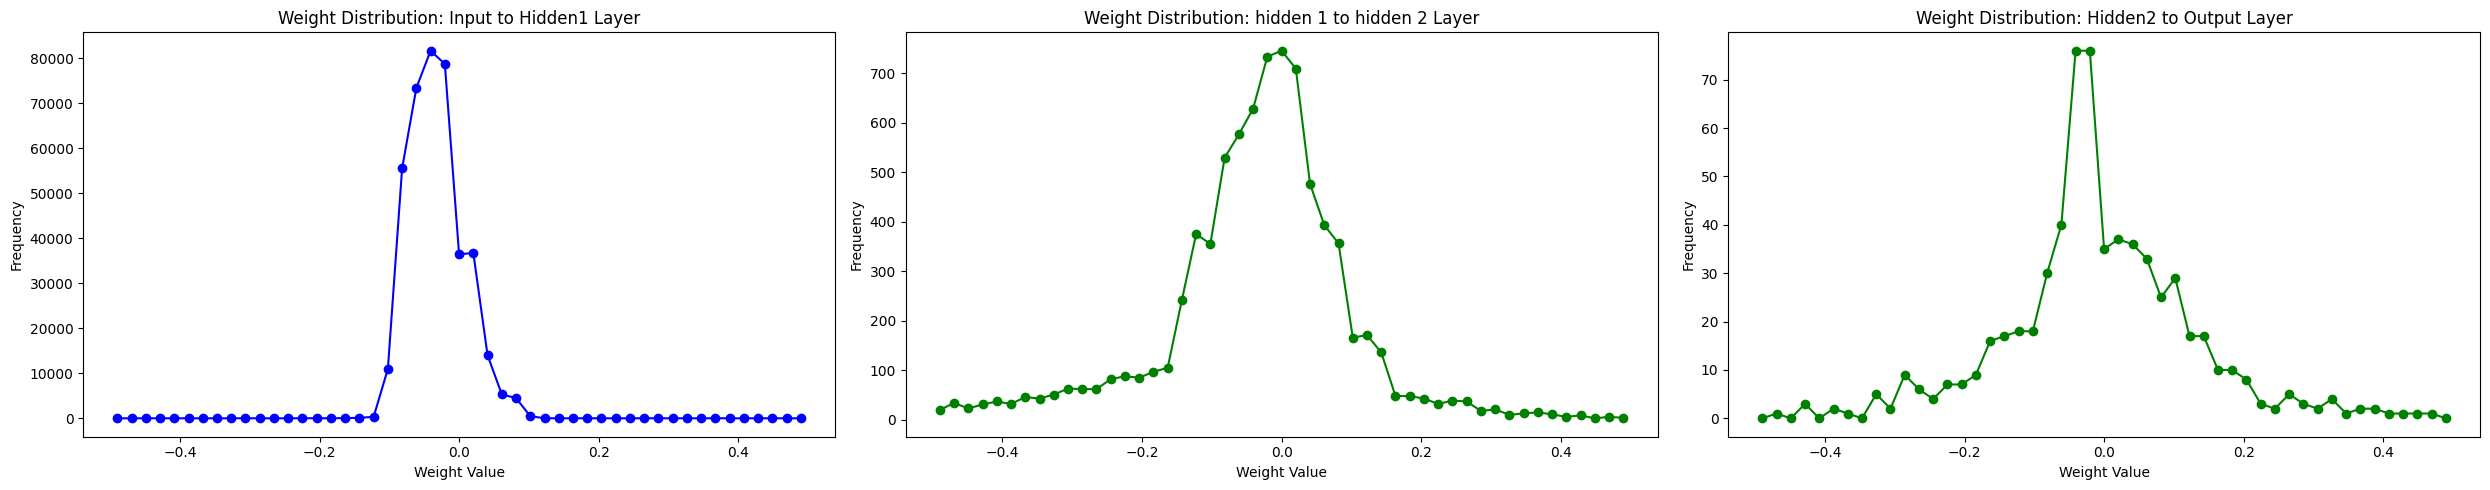

In [51]:
import matplotlib.pyplot as plt

fc_weights = model.fc.weight.cpu().detach().numpy().flatten()
fc2_weights = model.fc2.weight.cpu().detach().numpy().flatten()
out_weights = model.out.weight.cpu().detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
fc2_hist, fc2_bins = np.histogram(fc2_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
fc2_bin_centers = 0.5 * (fc2_bins[:-1] + fc2_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.plot(fc2_bin_centers, fc2_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: hidden 1 to hidden 2 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: Hidden2 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [52]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.01):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc2 = count_nonzero_weights_above_threshold(model.fc2, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc2}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3}')

Number of non-zero weights greater than 0.01 in layer 1: 365966
Number of non-zero weights greater than 0.01 in layer 1: 7462
Number of non-zero weights greater than 0.01 in layer 3: 605


In [53]:
for i in range(len(lay)):
    if i > 0 and i <= len(lay)-1:
        norms = []
        for j in range(lay[i-1][1].weight.shape[0]):
            norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))
        print(norms)
        norms = torch.tensor(norms)
        print(norms.shape)

[0.6836051558638829, 0.7001892668857618, 0.6911301303022993, 0.7057988124822323, 0.6879589525201452, 0.7232040590203461, 0.6989286381386509, 0.6872773609628366, 0.6843646796994819, 0.6874900989702569, 0.6686759554970249, 0.6697390507061399, 0.6790298591243797, 0.6060218922455337, 0.6506681445003176, 0.6559649117996398, 0.6908515540822048, 0.7291483890061609, 0.5829164063445289, 0.6852547886493361, 0.6928238338677986, 0.7210197369677196, 0.6511239116334607, 0.6972484567018461, 0.6737742116012398, 0.695186356052221, 0.6600716689253008, 0.6871562496258342, 0.6155354269250854, 0.6382252933241838, 0.5902228774548561, 0.7089964437098893, 0.5910200612568204, 0.7086979632496752, 0.6841047003283042, 0.6497777187247572, 0.7204973417246548, 0.5842363193181059, 0.6748894144719716, 0.698216814671496, 0.6552026940990618, 0.6305445591266764, 0.5837257095427172, 0.7556442135770286, 0.6355531976220782, 0.7133512400822158, 0.5955300268376127, 0.6857636640022841, 0.7058459494445677, 0.6883552347519932, 0

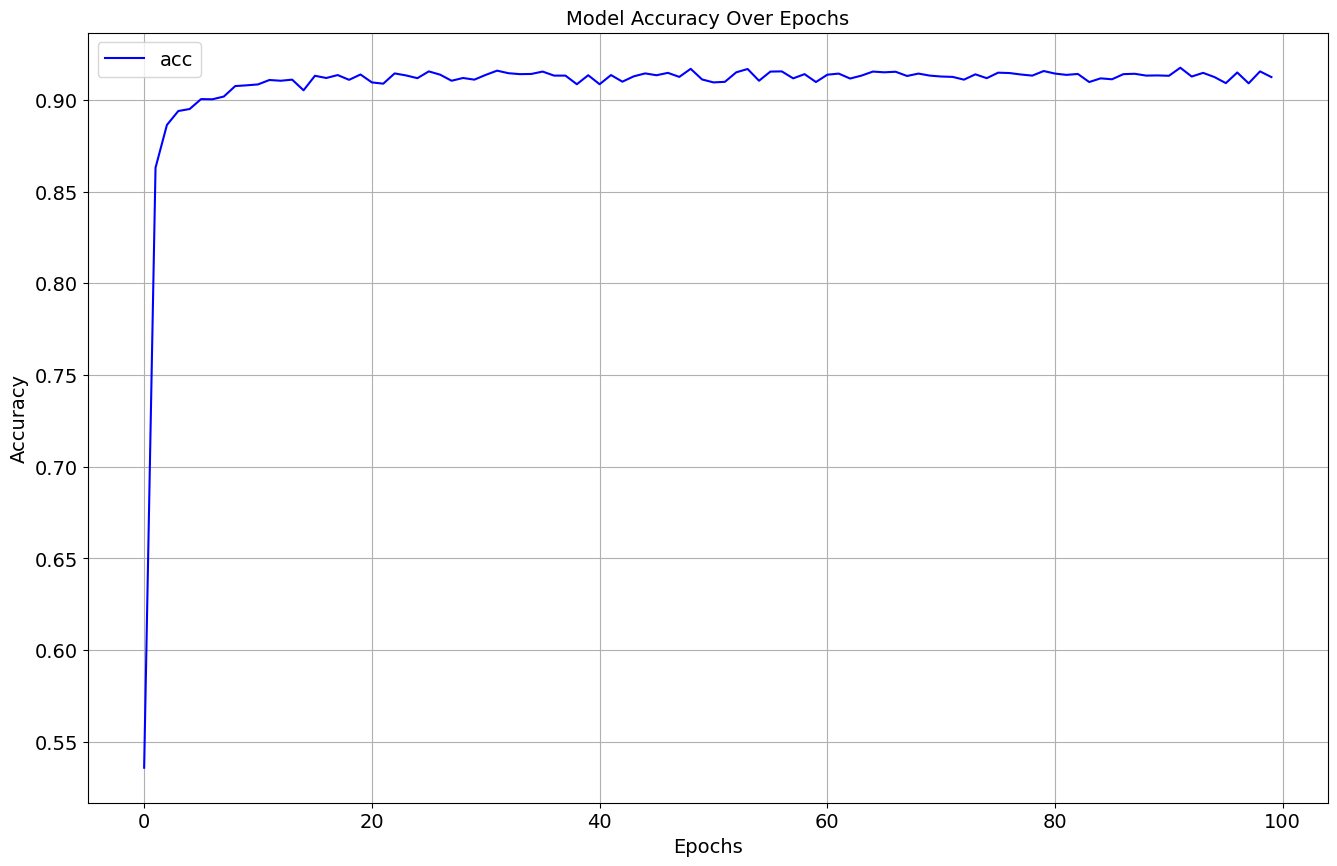

In [54]:
epochs_plot = list(range(100))

plt.figure(figsize=(16, 10))
plt.plot(epochs_plot, acc, linestyle='-', color='b', label='acc')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracy Over Epochs', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)

plt.legend(fontsize=14)

plt.show()

In [55]:
import pickle
with open('cleanAcc4.pkl', 'wb') as f:
    pickle.dump(acc, f)